## 6 Regress-Then-Rank by Machine Learning

In [1]:
# Cloud/Local Env Handling
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  PATH = "/content/drive/MyDrive/"
  PATH_INSTALL_REQUIREMENTS = "/content/drive/MyDrive/Colab\ Notebooks/requirements.txt"  
  import sys
  sys.path.append(PATH + "Colab Notebooks")
except:  
  import os
  if os.name=="nt":
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "\\requirements.txt"  
  else: #Unix system
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "/requirements.txt"  
  PATH=""

Mounted at /content/drive


In [ ]:
%pip install -r {PATH_INSTALL_REQUIREMENTS}

import pandas as pd
import yfinance as yf
import riskfolio.RiskFunctions as rf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import gc

# Custom Handmade Modules (please copy folder to Colab Notebooks root)
from modules import performance_measures_helper as pms
import importlib # for continuous reloading

# For Ratios with Extreme Values
from scipy.stats.mstats import winsorize

# For Serializing
import pickle

# Scikit-Learn
from sklearn.model_selection import train_test_split

### 6.1 Loading `targets` (raw + quantized)

In [ ]:
# raw_targets (Regress-then-Rank baseline problems)
targets = pd.read_csv(
    PATH + "fx_data/20220929_FX_raw_targets.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [ ]:
targets.head()

,symbols,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,
2004-05-24,AUD,0.006140,-0.024171,-0.014410,-5.465233e-03
2004-05-24,CAD,-0.009400,-0.015079,0.162377,-8.352494e-03
2004-05-24,CHF,-0.002923,0.745905,1.209960,3.521791e-01
2004-05-24,DKK,-0.000094,0.147710,0.991761,-1.622340e-07
2004-05-24,GBP,0.002996,-0.001824,0.031751,8.528283e-01


In [ ]:
targets.query("symbols=='USD'").loc[:,~targets.columns.isin(['symbols'])]

,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,
2004-05-24,-0.008423,-0.008212,0.475082,-0.001314
2004-05-25,-0.000823,-0.006114,0.521018,0.020972
2004-05-26,-0.013443,-0.015311,0.245995,-0.001528
2004-05-27,0.004738,-0.008879,0.011980,-0.001312
2004-05-28,0.001564,-0.007405,0.019877,0.031082
...,...,...,...,...
2022-09-23,0.015648,0.876819,1.635517,2.013569
2022-09-26,0.006880,0.973111,1.627804,2.074608
2022-09-27,0.002868,1.335994,1.747319,2.026638


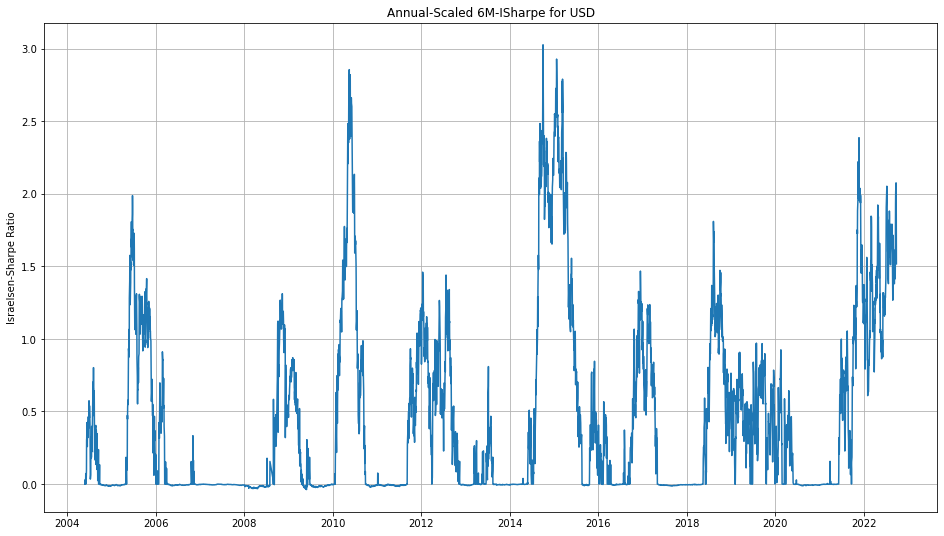

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(targets.query("symbols=='USD'")["RAWISR6M"])
#ax.plot(targets[targets["symbols"]=="USD"]["RAWISR6M"])

plt.grid()
ax.set_ylabel("Israelsen-Sharpe Ratio")
ax.set_title("Annual-Scaled 6M-ISharpe for USD");

### 6.2 Loading `features`

Next, we load 46 features based on performance, risk and past returns measures for the G11 currencies, excluding € which is considered as base currency

In [ ]:
predictors = pd.read_csv(
    PATH + "fx_data/20220930_FX_features.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [ ]:
%whos DataFrame


Variable     Type         Data/Info
-----------------------------------
predictors   DataFrame               symbols     MO<...>[47550 rows x 47 columns]
targets      DataFrame               symbols  RAWRE<...>n[47550 rows x 5 columns]


In [ ]:
predictors.head()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466


### 6.3 Feature Engineering and Baseline Modeling with `LinearRegression()`

In [ ]:
data = pd.merge(
    predictors,
    targets,
    how="inner",
    on=["Date","symbols"]    
)

In [ ]:
data.tail()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2022-09-29,JPY,0.012121,0.017806,-0.007876,0.005136,0.113193,-1.341665,-0.677560,0.760193,0.789695,...,-0.008030,0.350248,-0.005905,0.881938,1.038133,0.909191,-0.012595,-0.006250,-0.000036,-0.008213
2022-09-29,NOK,-0.018502,-0.030445,-0.053177,-0.003796,0.104257,-0.321431,-1.079341,-1.259888,-1.465918,...,-0.065416,-0.000728,-0.012870,0.388800,0.984594,0.778895,-0.010465,-0.017288,-0.004702,-0.012819
2022-09-29,NZD,-0.006492,-0.022662,-0.037018,-0.010162,0.084419,0.687908,-0.684954,-0.545918,-1.347578,...,-0.031333,-0.002428,-0.010787,0.369109,0.936174,0.763040,-0.008249,-0.010319,-0.003284,-0.010206
2022-09-29,SEK,0.000702,-0.020642,-0.018687,-0.014614,0.059045,0.113245,0.637721,0.084411,-1.754968,...,-0.010137,-0.002516,-0.006212,0.512307,0.863342,0.759255,-0.004518,-0.003898,-0.001773,-0.005240
2022-09-29,USD,0.012623,0.028415,0.032642,0.074759,0.108251,-1.691498,-0.159152,0.827814,1.317673,...,6.062488,5.086337,4.175389,1.709510,1.593394,1.485096,-0.012349,0.579849,1.124866,1.516582


In [ ]:
data.to_csv(
    "fx_data/20220929_FX_dataset_daily_raw_targets.csv",
    index=False
)

* Custom **Train, Test** Split:

No shuffling possible here. If sequential calibration -> _Walk-Forward Analysis_

In [ ]:
total_instances = len(data.index)
total_instances

47540

In [ ]:
instances_by_date = data["symbols"].nunique()

In [ ]:
total_dates = total_instances/instances_by_date
total_dates

4754.0

In [ ]:
test_dates = data["2019":].index.nunique() # Initial Guess for All The Initial Sample Under Consideration (Different for Sequential Training)
test_fraction = test_dates/total_dates
print(f"Train/Test Ansatz Split: ({100*(1-test_fraction):.1f}%, {100*test_fraction:.1f}%)")

Train/Test Ansatz Split: (79.4%, 20.6%)


In [ ]:
train_dates = total_dates-test_dates
split = int(total_instances*(1-test_dates/total_dates))
split

37770

In [ ]:
train = data.iloc[:split]
train.head(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331,-0.000117,-0.022878,-0.014408,-0.004832
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748,0.000362,-0.012096,0.109706,-0.007627
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825,0.000065,0.595035,1.174162,0.454858
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638,0.000108,0.375732,0.999559,0.140704
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466,0.000750,-0.000586,0.045550,0.936243


In [ ]:
test = data.iloc[split:]
test.head(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,AUD,-0.010183,-0.031430,-0.057585,-0.009233,0.082779,-0.989273,-1.792159,-0.873276,-1.905997,...,-0.063562,-0.002029,-0.003211,0.275329,0.932227,0.864372,0.003739,-0.016371,0.027216,-0.003111
2019-01-01,CAD,-0.008502,-0.026926,-0.039187,-0.055194,0.069292,-0.840631,-1.896561,-0.871092,-1.950686,...,-0.031777,-0.012500,-0.001508,0.320323,0.580722,0.933453,0.001986,-0.009227,-0.006190,-0.001168
2019-01-01,CHF,-0.005123,-0.004946,0.000353,0.005299,0.044046,-2.218748,-0.470495,-0.825688,-0.563713,...,0.159920,0.714751,1.630136,1.021220,1.088632,1.205166,0.005953,0.530316,0.674051,1.019281
2019-01-01,DKK,-0.000013,0.000121,-0.000526,-0.001426,0.002342,0.363128,-1.388600,-0.040454,0.258404,...,-0.000011,-0.000010,-0.000006,0.609460,0.622303,0.758536,0.000147,-0.000004,-0.000004,-0.000005
2019-01-01,GBP,-0.006317,-0.003103,-0.014297,-0.017200,0.065932,-0.258839,-0.637818,-0.680212,-0.236271,...,-0.008736,-0.003639,-0.001874,0.639995,0.843059,0.895866,0.004229,-0.001505,-0.002129,-0.001067


In [ ]:
# All In (Scaled Returns Next Month) 
# However, it is clear there is no linear relation and multicolinearity between predictors
corr = train.corr()
corr.style.background_gradient(
    cmap="coolwarm",
    vmin=-1,
    vmax=1
).set_precision(2)


/tmp/ipykernel_13329/979805347.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(


,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,ISR1M,ISR3M,ISR6M,SKR1M,SKR3M,SKR6M,VARR1M99,VARR1M95,VARR1M90,VARR1M80,VARR3M99,VARR3M95,VARR3M90,VARR3M80,VARR6M99,VARR6M95,VARR6M90,VARR6M80,RACHEV1M99,RACHEV1M95,RACHEV1M90,RACHEV1M80,RACHEV3M99,RACHEV3M95,RACHEV3M90,RACHEV3M80,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
MOM1W,1.00,0.69,0.48,0.28,0.02,0.38,0.66,0.86,0.60,0.42,0.35,0.22,0.17,0.05,0.04,0.03,-0.26,-0.28,-0.18,-0.10,-0.15,-0.18,-0.20,-0.21,-0.11,-0.14,-0.14,-0.15,0.00,0.00,0.01,0.01,0.00,-0.01,0.01,0.06,-0.00,0.01,0.03,0.15,0.23,0.25,0.20,0.24,0.29,0.22,-0.05,0.35,0.21,0.16
MOM2W,0.69,1.00,0.68,0.39,0.03,0.27,0.47,0.61,0.87,0.59,0.50,0.30,0.23,0.06,0.04,0.03,-0.35,-0.39,-0.26,-0.14,-0.20,-0.26,-0.28,-0.29,-0.15,-0.19,-0.20,-0.22,0.00,0.00,0.01,0.02,0.00,-0.00,0.01,0.09,-0.00,0.01,0.04,0.20,0.28,0.32,0.26,0.29,0.37,0.30,-0.04,0.49,0.30,0.23
MOM1M,0.48,0.68,1.00,0.57,0.04,0.19,0.33,0.42,0.59,0.87,0.73,0.43,0.33,0.08,0.06,0.05,-0.48,-0.55,-0.37,-0.21,-0.27,-0.35,-0.39,-0.41,-0.20,-0.26,-0.30,-0.31,0.00,0.02,0.01,0.03,0.00,0.00,0.01,0.13,-0.00,0.02,0.04,0.29,0.37,0.42,0.35,0.38,0.49,0.40,-0.03,0.69,0.43,0.33
MOM3M,0.28,0.39,0.57,1.00,0.08,0.11,0.20,0.25,0.34,0.49,0.40,0.75,0.55,0.01,0.07,0.05,-0.22,-0.28,-0.21,-0.12,-0.38,-0.54,-0.65,-0.68,-0.26,-0.41,-0.49,-0.50,0.01,0.01,0.01,0.02,0.00,0.02,0.03,0.22,0.00,0.04,0.08,0.48,0.20,0.68,0.54,0.21,0.78,0.62,-0.02,0.38,0.73,0.55
EWVOL3M,0.02,0.03,0.04,0.08,1.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.08,-0.01,-0.01,-0.01,0.03,0.02,-0.00,0.01,0.04,0.05,0.01,-0.04,0.11,0.05,0.00,-0.04,-0.00,0.00,-0.01,-0.00,-0.00,0.01,0.01,0.01,0.00,0.01,0.01,0.07,0.04,0.07,0.12,0.04,0.09,0.12,0.01,0.00,0.02,0.08
SRET1D,0.38,0.27,0.19,0.11,0.00,1.00,0.57,0.44,0.32,0.23,0.19,0.12,0.09,0.03,0.03,0.01,-0.15,-0.15,-0.11,-0.05,-0.08,-0.10,-0.10,-0.11,-0.05,-0.07,-0.08,-0.08,0.00,-0.00,0.00,0.01,-0.00,-0.01,0.01,0.03,-0.00,0.00,0.02,0.08,0.10,0.12,0.09,0.10,0.13,0.10,-0.03,0.18,0.12,0.09
SRET3D,0.66,0.47,0.33,0.20,0.00,0.57,1.00,0.77,0.55,0.39,0.33,0.21,0.16,0.05,0.03,0.02,-0.25,-0.27,-0.18,-0.09,-0.14,-0.17,-0.18,-0.19,-0.09,-0.12,-0.13,-0.14,0.00,0.00,0.01,0.01,0.00,-0.01,0.01,0.05,-0.01,0.01,0.03,0.14,0.17,0.20,0.16,0.18,0.22,0.17,-0.03,0.32,0.20,0.15
SRET1W,0.86,0.61,0.42,0.25,0.00,0.44,0.77,1.00,0.70,0.49,0.42,0.26,0.20,0.06,0.04,0.03,-0.30,-0.34,-0.22,-0.12,-0.17,-0.22,-0.24,-0.24,-0.11,-0.15,-0.17,-0.18,0.00,0.00,0.01,0.01,0.00,-0.01,0.00,0.08,-0.00,0.01,0.03,0.18,0.21,0.25,0.20,0.21,0.28,0.22,-0.02,0.41,0.26,0.20
SRET2W,0.60,0.87,0.59,0.34,0.00,0.32,0.55,0.70,1.00,0.69,0.59,0.36,0.28,0.07,0.04,0.03,-0.40,-0.46,-0.31,-0.17,-0.22,-0.30,-0.33,-0.34,-0.15,-0.21,-0.24,-0.25,-0.00,0.01,0.01,0.02,0.00,0.00,0.01,0.11,-0.00,0.02,0.04,0.25,0.28,0.33,0.27,0.29,0.38,0.30,-0.02,0.58,0.35,0.27
SRET1M,0.42,0.59,0.87,0.49,0.01,0.23,0.39,0.49,0.69,1.00,0.85,0.50,0.38,0.09,0.06,0.04,-0.55,-0.65,-0.44,-0.24,-0.29,-0.40,-0.46,-0.47,-0.20,-0.29,-0.34,-0.35,0.00,0.02,0.02,0.03,0.00,0.00,0.01,0.15,-0.00,0.02,0.05,0.34,0.40,0.45,0.37,0.40,0.52,0.41,-0.01,0.80,0.50,0.38


In [ ]:
# Reconfiguring for sklearn, tf-keras
# Train Set
y_train = train.loc[:,["RAWISR3M"]]
X_train = train.loc[:,~train.columns.isin(["symbols","RAWRET1DAH","RAWISR1M","RAWISR3M","RAWISR6M"])] # Initially we does not consider to encode Currency as an Additional Feature
# Test Set 
y_test = test.loc[:,["RAWISR3M"]]
X_test = test.loc[:,~train.columns.isin(["symbols","RAWRET1DAH","RAWISR1M","RAWISR3M","RAWISR6M"])]

In [ ]:
y_train.isna().sum()

RAWISR3M    0
dtype: int64

In [ ]:
X_train

,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,-1.570884,...,58.866322,20.157627,10.345165,4.280637,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,-1.053603,...,23.561574,10.452677,6.076980,3.183850,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,0.689485,...,3639.860705,21.719801,8.922454,4.076541,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,0.115450,...,74.860526,16.525860,8.542702,4.150863,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,-0.226643,...,73.998659,84.569047,16.796542,5.520228,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,0.000341,0.015406,0.023311,0.039169,0.068112,0.958100,-0.263260,0.035499,1.135443,1.185568,...,216.914950,25.910436,9.897034,3.989189,10.573045,4.021342,1.024691e+00,2.186265,1.454315,1.114922
2018-12-31,0.001247,-0.021955,-0.024044,-0.052596,0.060208,1.442600,0.367086,0.147021,-1.830548,-1.383402,...,21.397244,10.474178,6.250253,3.375089,-0.018078,-0.010236,-4.652841e-03,0.475308,0.505669,0.706600
2018-12-31,-0.007301,-0.024313,-0.027104,0.028025,0.086974,0.100608,-0.634025,-0.595942,-1.403298,-1.079546,...,369.671432,22.298551,9.786237,4.426369,-0.027664,1.937340,3.991598e-01,0.601019,1.237701,1.047407


In [ ]:
X_train.describe().loc["max",:]

MOM1W         2.102076e-01
MOM2W         2.248455e-01
MOM1M         3.324727e-01
MOM3M         4.496083e-01
EWVOL3M       6.630379e-01
SRET1D        5.702393e+00
SRET3D        4.120339e+00
SRET1W        4.246628e+00
SRET2W        4.055216e+00
SRET1M        3.636990e+00
ISR1M         4.615173e+00
ISR3M         3.306286e+00
ISR6M         3.402702e+00
SKR1M         2.372829e+00
SKR3M         3.182765e+00
SKR6M         3.076750e+00
VARR1M99      4.469305e+01
VARR1M95      2.892298e+01
VARR1M90               inf
VARR1M80               inf
VARR3M99      8.797302e+00
VARR3M95      6.374162e+00
VARR3M90      3.227575e+00
VARR3M80      4.565336e+00
VARR6M99      3.547225e+00
VARR6M95      2.508594e+00
VARR6M90      2.142819e+00
VARR6M80      2.688150e+00
RACHEV1M99    1.202984e+06
RACHEV1M95    2.035014e+05
RACHEV1M90    3.130043e+05
RACHEV1M80    1.196237e+05
RACHEV3M99    1.709493e+07
RACHEV3M95    1.484308e+06
RACHEV3M90    4.634649e+05
RACHEV3M80    9.911209e+02
RACHEV6M99    4.085656e+06
R

In [ ]:
X_train.describe().loc["max",:].describe()

count    4.400000e+01
mean     5.738827e+05
std      2.634862e+06
min      2.102076e-01
25%      3.216373e+00
50%      6.038277e+00
75%      1.062863e+03
max      1.709493e+07
Name: max, dtype: float64

In [ ]:
X_test.describe().loc["max",:].describe()

count        44.000000
mean      27301.126216
std       76336.005783
min           0.078933
25%           2.623825
50%           4.017327
75%         187.531640
max      389926.540629
Name: max, dtype: float64

In [ ]:
X_train.iloc[:,-4:]

,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,
2004-05-25,-6.285969e-03,0.385849,0.720941,0.875331
2004-05-25,-8.575954e-03,0.629543,1.050538,0.828748
2004-05-25,7.449488e-01,1.559042,1.463008,1.085825
2004-05-25,-1.595831e-07,1.098828,1.462902,0.995638
2004-05-25,1.711806e+00,0.898997,1.010222,1.217466
...,...,...,...,...
2018-12-31,1.024691e+00,2.186265,1.454315,1.114922
2018-12-31,-4.652841e-03,0.475308,0.505669,0.706600
2018-12-31,3.991598e-01,0.601019,1.237701,1.047407


#### 6.3.1 Baseline Naive Linear Regression (`sklearn`)

<AxesSubplot:ylabel='Density'>

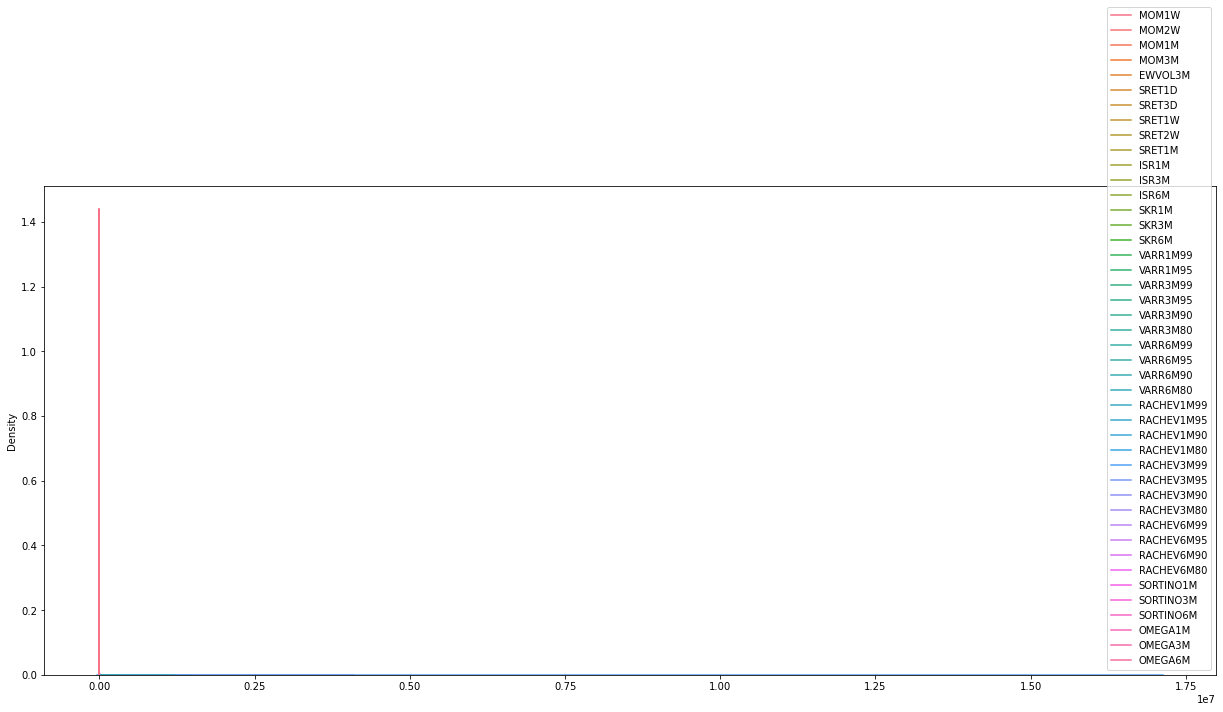

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(21,9))
sns.kdeplot(data=X_train)

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rb = RobustScaler()
minmax = MinMaxScaler()

In [ ]:
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

<AxesSubplot:ylabel='Density'>

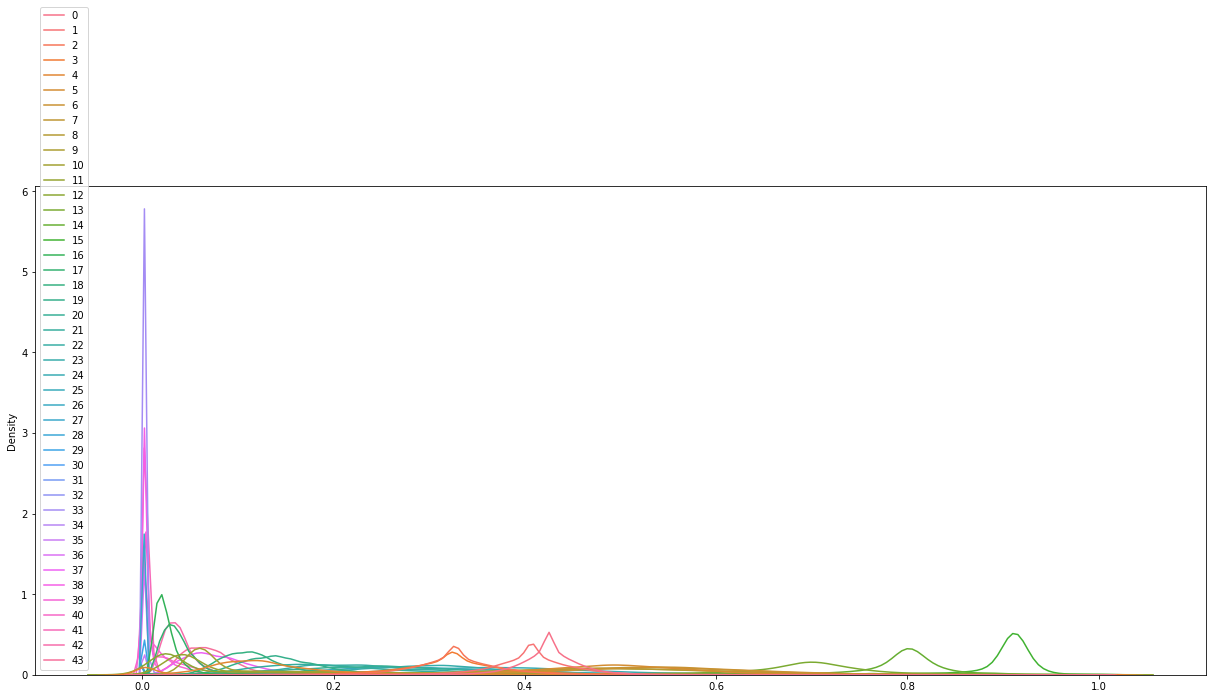

In [ ]:
fig, ax = plt.subplots(figsize=(21,9))
sns.kdeplot(data=X_train_scaled)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(
    X_train_scaled,
    y_train
)

LinearRegression()

In [ ]:
lr.coef_

array([[-3.94000270e-02, -4.99613124e-02, -4.90020932e-04,
         1.64083637e-02, -5.16347010e-03, -2.71386207e-03,
        -1.04469990e-02,  1.08094879e-02, -2.85652555e-04,
         2.18724730e-02,  6.10090576e-02,  3.24197247e+00,
         1.37990833e-01,  2.22211586e-03,  1.45124886e-02,
        -6.90535056e-03, -2.88836895e-02,  4.69532435e-02,
         7.15765455e-02, -3.68593583e-02,  5.55344364e-03,
         2.02664832e-02, -1.19769595e-02,  1.01892394e-02,
         3.63302213e-03, -2.22323523e-02,  1.48754558e-01,
         6.00059289e-02, -1.98407369e-03, -4.17371217e-02,
        -1.45942037e-03,  5.44745612e-02,  7.47305254e-02,
         1.79451790e-01,  3.65689256e-02, -7.03421678e-02,
         8.39421434e-02, -9.74885321e-02, -7.71088005e-01,
        -5.14561334e-01, -4.76643890e-01,  4.39875708e-01,
         1.37055994e+00, -1.58217163e-01]])

In [ ]:
y_test

,RAWISR3M
Date,
2019-01-01,0.027216
2019-01-01,-0.006190
2019-01-01,0.674051
2019-01-01,-0.000004
2019-01-01,-0.002129
...,...
2022-09-29,-0.000036
2022-09-29,-0.004702
2022-09-29,-0.003284


In [ ]:
X_test_scaled

array([[0.39727252, 0.32428957, 0.21042   , ..., 0.00093033, 0.03139225,
        0.04820983],
       [0.4018682 , 0.33616568, 0.24766249, ..., 0.00113562, 0.01457817,
        0.05678773],
       [0.41111022, 0.39411851, 0.32770206, ..., 0.0043336 , 0.03887381,
        0.09052676],
       ...,
       [0.40736664, 0.34740807, 0.25205308, ..., 0.00135822, 0.03158108,
        0.03562739],
       [0.42704009, 0.3527335 , 0.28915863, ..., 0.00201158, 0.02809719,
        0.03515738],
       [0.45964081, 0.48207906, 0.3930623 , ..., 0.00747406, 0.06301886,
        0.12528595]])

In [ ]:
y_pred = lr.predict(X_test_scaled)

In [ ]:
# In-Sample (High Fitting)
print(f"Train R^2: {100*lr.score(X_train_scaled, y_train):.2f}%") # High Signal-To-Noise Ratio

# Out-Of-Sample (High As Well, but not necessarily high accuracy after translating into predicted ranks -> Try Ordinal Regression)
print(f"Test R^2: {100*lr.score(X_test_scaled, y_test):.2f}%")

Train R^2: 94.06%
Test R^2: 92.86%


In [ ]:
# More Metrics
from sklearn import metrics
metrics.mean_absolute_error(y_test, y_pred)

0.08328894330569903

In [ ]:
y_train.shape

(37770, 1)

In [ ]:
from sklearn import feature_selection
sfs = feature_selection.SequentialFeatureSelector(
    estimator=lr,
    n_features_to_select=10,
    direction="forward",
    scoring="r2"
)

In [ ]:
sfs.fit(X_train_scaled, y_train)
sfs.support_

array([False,  True, False,  True, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False])

In [ ]:
features_selected = X_train.columns[sfs.support_].tolist()
features_selected

['MOM2W',
 'MOM3M',
 'SRET1M',
 'ISR1M',
 'ISR3M',
 'ISR6M',
 'VARR3M95',
 'VARR3M80',
 'VARR6M95',
 'OMEGA1M']

In [ ]:
lr_sfs = LinearRegression()

X_train_sc = rb.fit_transform(X_train[features_selected])
X_test_sc = rb.transform(X_test[features_selected])

lr_sfs.fit(X_train_sc, y_train)

LinearRegression()

In [ ]:
X_test_sc.shape, y_test.shape

((9770, 10), (9770, 1))

In [ ]:
y_test.drop(columns=["RAWISR3M_LR"], inplace=True)

In [ ]:
lr_sfs.score(X_test_sc, y_test)

0.9285867858434791

In [ ]:
y_pred = lr_sfs.predict(X_test_sc)
y_pred

array([[ 0.0048871 ],
       [-0.00906671],
       [ 0.2677339 ],
       ...,
       [ 0.0072236 ],
       [ 0.01133243],
       [ 1.37097397]])

In [ ]:
y_pred.shape

(9770, 1)

In [ ]:
y_test["RAWISR3M_LR"] = y_pred
y_test

,RAWISR3M,RAWISR3M_LR
Date,,
2019-01-01,0.027216,0.004887
2019-01-01,-0.006190,-0.009067
2019-01-01,0.674051,0.267734
2019-01-01,-0.000004,-0.003305
2019-01-01,-0.002129,0.006805
...,...,...
2022-09-29,-0.000036,0.123148
2022-09-29,-0.004702,0.012674
2022-09-29,-0.003284,0.007224


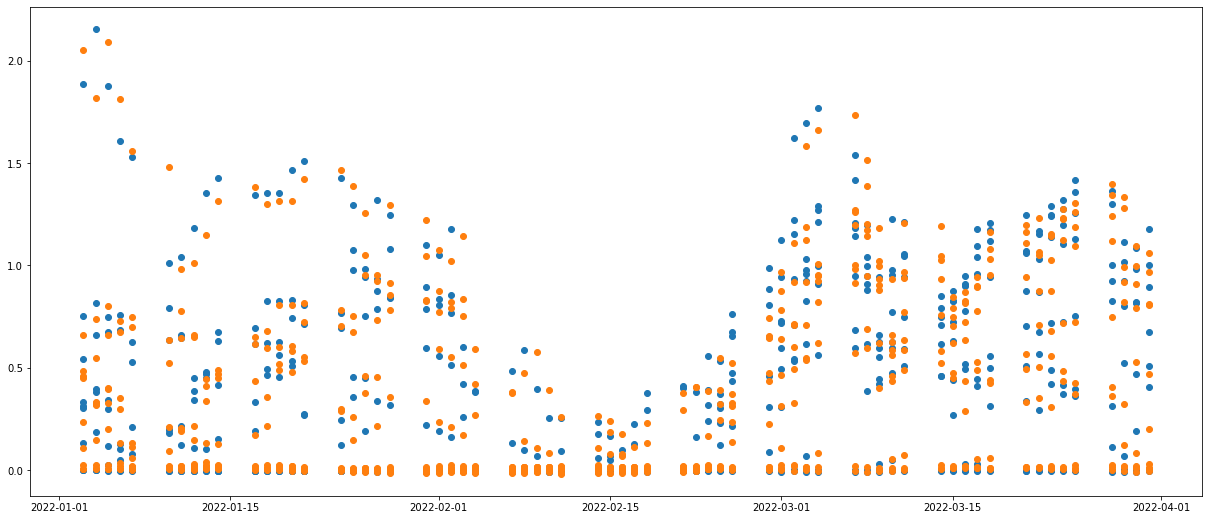

In [ ]:
import matplotlib.pyplot as plt

#fig, (ax1,ax2) = plt.subplots(2,1, figsize=(21,9))
fig, ax2 = plt.subplots(1,1, figsize=(21,9))
#ax1.plot(y_train, marker="o")
ax2.plot(y_test["2022-01":"2022-03"], marker="o", linestyle="");

In [ ]:
X_train.tail()

,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.000341,0.015406,0.023311,0.039169,0.068112,0.958100,-0.263260,0.035499,1.135443,1.185568,...,216.914950,25.910436,9.897034,3.989189,10.573045,4.021342,1.024691,2.186265,1.454315,1.114922
2018-12-31,0.001247,-0.021955,-0.024044,-0.052596,0.060208,1.442600,0.367086,0.147021,-1.830548,-1.383402,...,21.397244,10.474178,6.250253,3.375089,-0.018078,-0.010236,-0.004653,0.475308,0.505669,0.706600
2018-12-31,-0.007301,-0.024313,-0.027104,0.028025,0.086974,0.100608,-0.634025,-0.595942,-1.403298,-1.079546,...,369.671432,22.298551,9.786237,4.426369,-0.027664,1.937340,0.399160,0.601019,1.237701,1.047407
2018-12-31,0.000840,-0.003125,0.005169,0.012791,0.059882,0.691579,0.754762,0.099591,-0.261942,0.299010,...,58.829053,13.671854,7.324387,3.447077,1.458125,1.384202,-0.000100,1.156082,1.150455,0.993588
2018-12-31,-0.005868,-0.011713,-0.004124,0.009773,0.064648,-0.190858,-0.302625,-0.644430,-0.909517,-0.220985,...,119.368106,30.502123,10.887670,4.227297,-0.001967,0.966508,1.064030,0.884290,1.104506,1.118376


In [ ]:
print(f"{X_train['2017':'2018'].shape[0]/10}")
print(f"{X_train.shape[0]/10}")

validation_dates = X_train['2017':'2018'].shape[0]/10
all_train_dates = X_train.shape[0]/10

validation_fraction_ = validation_dates/all_train_dates
print(f"{100*validation_fraction_:.2f}%")

519.0
3777.0
13.74%


In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=[512],
    random_state=20221101,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=validation_fraction_, #1.5y (with no shuffle) for validation
    shuffle=False    
    )

mlp.fit(X_train_scaled, y_train.values.ravel())
pred = mlp.predict(X_train_scaled)

In [ ]:
(
    y_test.drop(
        columns=y_test.columns.tolist()[-1],
        inplace=True
    )
)


In [ ]:
y_test

,RAWISR3M
Date,
2019-01-01,0.027216
2019-01-01,-0.006190
2019-01-01,0.674051
2019-01-01,-0.000004
2019-01-01,-0.002129
...,...
2022-09-29,-0.000036
2022-09-29,-0.004702
2022-09-29,-0.003284


In [ ]:
# In-Sample (Very Poor Fitting)
print(f"Train R^2: {100*mlp.score(X_train_scaled, y_train):.2f}%") # Poor Signal-To-Noise Ratio
# Out-Of-Sample (Poor as Well) -> As Expected
print(f"Test R^2: {100*mlp.score(X_test_scaled, y_test):.2f}%")

Train R^2: 93.22%
Test R^2: 91.93%


**CONCLUSIONS (LR and MLP with All Features)**

1. Plain-Vanilla Linear Models when considering the whole sample and with a 80%, 20% split, are working reasonably well if the 3M-window ISR observed one-period ahead is chosen as the target (response).

2. Let us derive the OOS performances to get an insight if this finding is relevant or not in terms of forward cumulative returns

#### 6.3.2 Out-Of-Sample Performance

In [ ]:
predictions_tidy = test.loc[:,["symbols"]]
predictions_tidy["RAWISR3M_LR"] = y_pred
predictions_tidy

,symbols,RAWISR3M_LR
Date,,
2019-01-01,AUD,0.004887
2019-01-01,CAD,-0.009067
2019-01-01,CHF,0.267734
2019-01-01,DKK,-0.003305
2019-01-01,GBP,0.006805
...,...,...
2022-09-29,JPY,0.123148
2022-09-29,NOK,0.012674
2022-09-29,NZD,0.007224


In [ ]:
predictions_tidy.reset_index(inplace=True)
predictions_tidy

,Date,symbols,RAWISR3M_LR
0,2019-01-01,AUD,0.004887
1,2019-01-01,CAD,-0.009067
2,2019-01-01,CHF,0.267734
3,2019-01-01,DKK,-0.003305
4,2019-01-01,GBP,0.006805
...,...,...,...
9765,2022-09-29,JPY,0.123148
9766,2022-09-29,NOK,0.012674
9767,2022-09-29,NZD,0.007224
9768,2022-09-29,SEK,0.011332


In [ ]:
%whos DataFrame

Variable           Type         Data/Info
-----------------------------------------
X_test             DataFrame                   MOM1W     <...>n[9770 rows x 44 columns]
X_train            DataFrame                   MOM1W     <...>[37770 rows x 44 columns]
corr               DataFrame                   MOM1W     <...>n\n[50 rows x 50 columns]
data               DataFrame               symbols     MO<...>[47540 rows x 51 columns]
predictions        DataFrame               Date symbols  <...>\n[9770 rows x 3 columns]
predictions_rank   DataFrame    symbols     AUD  CAD   CH<...>\n[977 rows x 10 columns]
predictions_tidy   DataFrame               Date symbols  <...>\n[9770 rows x 3 columns]
predictions_ts     DataFrame    symbols          AUD     <...>\n[977 rows x 10 columns]
predictions_wide   DataFrame    symbols          AUD     <...>\n[977 rows x 10 columns]
predictors         DataFrame               symbols     MO<...>[47550 rows x 47 columns]
targets            DataFrame        

In [ ]:
del predictions, predictions_rank, predictions_ts
import gc
gc.collect()

4721

In [ ]:
%whos ndarray

Variable         Type       Data/Info
-------------------------------------
X_test_sc        ndarray    9770x10: 97700 elems, type `float64`, 781600 bytes (763.28125 kb)
X_test_scaled    ndarray    9770x44: 429880 elems, type `float64`, 3439040 bytes (3.27972412109375 Mb)
X_train_sc       ndarray    37770x10: 377700 elems, type `float64`, 3021600 bytes (2.881622314453125 Mb)
X_train_scaled   ndarray    37770x44: 1661880 elems, type `float64`, 13295040 bytes (12.67913818359375 Mb)
pred             ndarray    37770: 37770 elems, type `float64`, 302160 bytes (295.078125 kb)
y_pred           ndarray    9770x1: 9770 elems, type `float64`, 78160 bytes


In [ ]:
predictions_wide = pd.pivot(
    predictions_tidy,
    index=["Date"],
    columns="symbols",
    values="RAWISR3M_LR"
)

In [ ]:
from modules import performance_measures_helper as pms

predictions_rank_wide = predictions_wide.rank(axis=1)
predictions_rank_wide

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,4.0,1.0,7.0,3.0,5.0,10.0,2.0,8.0,9.0,6.0
2019-01-02,5.0,2.0,7.0,3.0,4.0,10.0,1.0,9.0,8.0,6.0
2019-01-03,5.0,2.0,8.0,3.0,4.0,10.0,1.0,9.0,7.0,6.0
2019-01-04,5.0,2.0,8.0,3.0,4.0,10.0,1.0,9.0,7.0,6.0
2019-01-07,5.0,3.0,7.0,2.0,4.0,9.0,1.0,10.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,7.0,8.0,9.0,6.0,1.0,5.0,4.0,3.0,2.0,10.0
2022-09-26,7.0,8.0,9.0,5.0,1.0,6.0,4.0,3.0,2.0,10.0
2022-09-27,7.0,8.0,9.0,5.0,1.0,6.0,4.0,2.0,3.0,10.0


In [ ]:
fx_rates = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [ ]:
best_curr = (predictions_rank_wide==10).shift(1)
worst_curr = (predictions_rank_wide==1).shift(1)

In [ ]:
best_curr.head()

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,False,False,False,False,False,True,False,False,False,False
2019-01-03,False,False,False,False,False,True,False,False,False,False
2019-01-04,False,False,False,False,False,True,False,False,False,False
2019-01-07,False,False,False,False,False,True,False,False,False,False


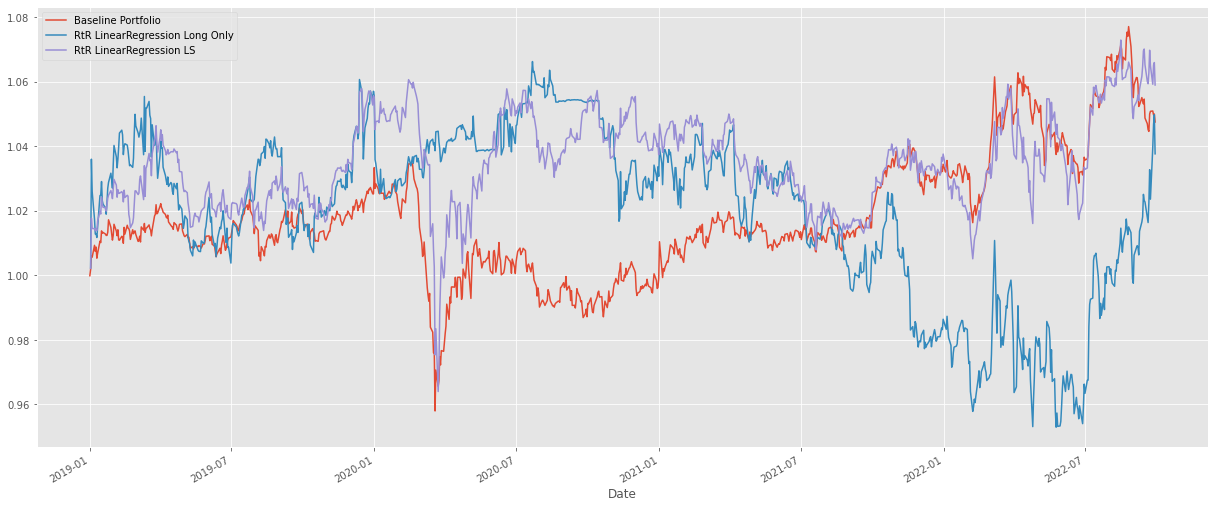

In [ ]:
plt.style.use("ggplot")

(1+fx_rates.pct_change()[best_curr.index[0]:].mean(axis=1,skipna=True)).rename("Baseline Portfolio").cumprod().plot(figsize=(21,9), legend=True)
(1+fx_rates.pct_change()[best_curr].mean(axis=1)).rename("RtR LinearRegression Long Only").cumprod().plot(legend=True);
(1+0.5*fx_rates.pct_change()[best_curr].mean(axis=1)+0.5*fx_rates.pct_change()[worst_curr].mean(axis=1)).rename("RtR LinearRegression LS").cumprod().plot(legend=True);

#plt.semilogy();


In [ ]:
# 92% on test is not enough to outperform baseline portfolio (if market fees considered), but a good starting point.
# Don't forget we are working with a very simple plain-vanilla MultiVariate Reg. 
# Higher Scores could improve OOS performances.

# Test/Compare with perfect ranking
%whos DataFrame

Variable                Type         Data/Info
----------------------------------------------
X_test                  DataFrame                   MOM1W     <...>n[9770 rows x 44 columns]
X_train                 DataFrame                   MOM1W     <...>[37770 rows x 44 columns]
best_curr               DataFrame    symbols       AUD    CAD <...>\n[977 rows x 10 columns]
corr                    DataFrame                   MOM1W     <...>n\n[50 rows x 50 columns]
data                    DataFrame               symbols     MO<...>[47540 rows x 51 columns]
fx_rates                DataFrame                     AUD     <...>n[4880 rows x 10 columns]
predictions_rank_wide   DataFrame    symbols     AUD  CAD   CH<...>\n[977 rows x 10 columns]
predictions_tidy        DataFrame               Date symbols  <...>\n[9770 rows x 3 columns]
predictions_wide        DataFrame    symbols          AUD     <...>\n[977 rows x 10 columns]
predictors              DataFrame               symbols     MO<...>[4

In [ ]:
data.head()

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331,-0.000117,-0.022878,-0.014408,-0.004832
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748,0.000362,-0.012096,0.109706,-0.007627
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825,0.000065,0.595035,1.174162,0.454858
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638,0.000108,0.375732,0.999559,0.140704
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466,0.000750,-0.000586,0.045550,0.936243


In [ ]:
observed_rank_tidy = pd.read_csv(
    PATH + "fx_data/20220929_FX_quantized_targets.csv",
    index_col="Date",
    parse_dates=["Date"]
)[["symbols","ISR3M"]]

In [ ]:
observed_rank_tidy

,symbols,ISR3M
Date,,
2004-05-24,AUD,2
2004-05-24,CAD,5
2004-05-24,CHF,9
2004-05-24,DKK,8
2004-05-24,GBP,3
...,...,...
2022-09-29,JPY,6
2022-09-29,NOK,1
2022-09-29,NZD,3


In [ ]:
best_currency = observed_rank_tidy.query("ISR3M==10")[["symbols"]]

In [ ]:
best_currency["symbols_1"] = best_currency["symbols"].shift(1)

,symbols,symbols_1
Date,,
2004-05-24,NOK,NaN
2004-05-25,NOK,NOK
2004-05-26,NOK,NOK
2004-05-27,NOK,NOK
2004-05-28,CHF,NOK
...,...,...
2022-09-23,USD,USD
2022-09-26,USD,USD
2022-09-27,USD,USD


In [ ]:
best_currency["trade"] = (best_currency["symbols_1"]!=best_currency["symbols"]).astype("int").shift(1)

**Estimating Trading** costs [based on well-known IBKR Broker](https://www.interactivebrokers.com/en/pricing/commissions-spot-currencies.php)


In [ ]:
best_currency["trade_cost"]=best_currency["trade"]*0.02/100 #10,000 to 100,000 Trade Values for IBKR (first estimate)

In [ ]:
best_currency

,symbols,symbols_1,trade,trade_cost
Date,,,,
2004-05-24,NOK,NaN,NaN,NaN
2004-05-25,NOK,NOK,1.0,0.0002
2004-05-26,NOK,NOK,0.0,0.0000
2004-05-27,NOK,NOK,0.0,0.0000
2004-05-28,CHF,NOK,0.0,0.0000
...,...,...,...,...
2022-09-23,USD,USD,1.0,0.0002
2022-09-26,USD,USD,0.0,0.0000
2022-09-27,USD,USD,0.0,0.0000


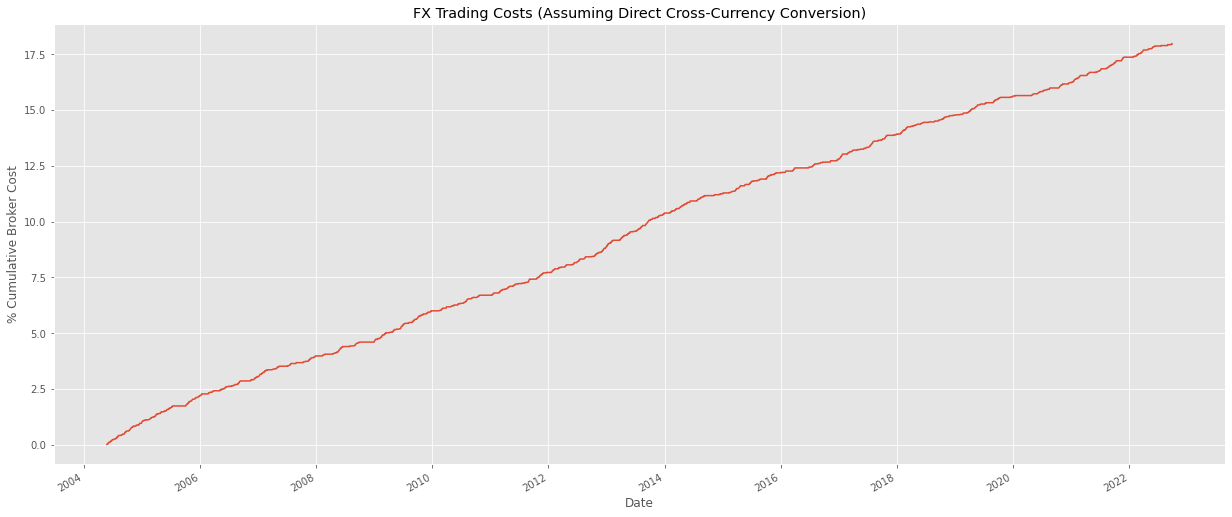

In [ ]:
(
    (100*best_currency["trade_cost"])
    .cumsum()
    .rename("Cumulative # FX Trades")
    .plot(
        figsize=(21,9),
        title="FX Trading Costs (Assuming Direct Cross-Currency Conversion)",
        ylabel="% Cumulative Broker Cost"
        )
);

In [ ]:
observed_rank_tidy

,symbols,ISR3M
Date,,
2004-05-24,AUD,2
2004-05-24,CAD,5
2004-05-24,CHF,9
2004-05-24,DKK,8
2004-05-24,GBP,3
...,...,...
2022-09-29,JPY,6
2022-09-29,NOK,1
2022-09-29,NZD,3


In [ ]:
observed_rank_wide = pd.pivot(
    observed_rank_tidy.reset_index(),
    index="Date",
    columns="symbols",
    values="ISR3M"
)

observed_rank_wide

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-24,2,5,9,8,3,4,10,1,7,6
2004-05-25,2,4,9,8,3,5,10,1,7,6
2004-05-26,2,4,9,8,5,3,10,1,7,6
2004-05-27,2,3,9,8,4,6,10,1,7,5
2004-05-28,2,3,10,8,5,6,9,1,7,4
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,7,8,9,5,1,6,4,3,2,10
2022-09-26,6,8,9,5,1,7,4,3,2,10
2022-09-27,6,8,9,5,1,7,4,2,3,10


In [ ]:
perfect_mask = (observed_rank_wide==10).shift(1)

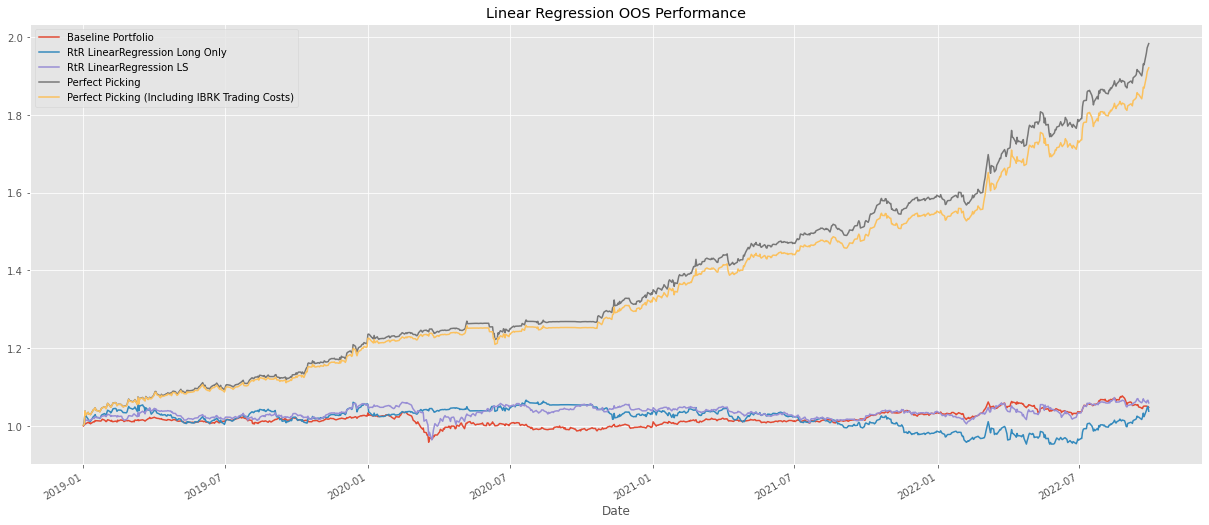

In [ ]:
plt.style.use("ggplot")

(1+fx_rates.pct_change()[best_curr.index[0]:].mean(axis=1,skipna=True)).rename("Baseline Portfolio").cumprod().plot(figsize=(21,9), legend=True, title="Linear Regression OOS Performance")

(1+fx_rates.pct_change()[best_curr].mean(axis=1)).rename("RtR LinearRegression Long Only").cumprod().plot(legend=True);
(1+0.5*fx_rates.pct_change()[best_curr].mean(axis=1)+0.5*fx_rates.pct_change()[worst_curr].mean(axis=1)).rename("RtR LinearRegression LS").cumprod().plot(legend=True);

(1+fx_rates.pct_change()[best_curr.index[0]:][perfect_mask].mean(axis=1)).rename("Perfect Picking").cumprod().plot(legend=True);
(1+fx_rates.pct_change()[best_curr.index[0]:][perfect_mask].mean(axis=1)-best_currency["trade_cost"]).rename("Perfect Picking (Including IBRK Trading Costs)").cumprod().plot(legend=True);

#plt.semilogy();

In [ ]:
%whos DataFrame

Variable                Type         Data/Info
----------------------------------------------
X_test                  DataFrame                   MOM1W     <...>n[9770 rows x 44 columns]
X_train                 DataFrame                   MOM1W     <...>[37770 rows x 44 columns]
best_curr               DataFrame    symbols       AUD    CAD <...>\n[977 rows x 10 columns]
best_currency           DataFrame               symbols symbol<...>\n[4755 rows x 4 columns]
corr                    DataFrame                   MOM1W     <...>n\n[50 rows x 50 columns]
data                    DataFrame               symbols     MO<...>[47540 rows x 51 columns]
fx_rates                DataFrame                     AUD     <...>n[4880 rows x 10 columns]
observed_rank_tidy      DataFrame               symbols  ISR3M<...>n[47550 rows x 2 columns]
observed_rank_wide      DataFrame    symbols     AUD  CAD  CHF<...>n[4755 rows x 10 columns]
perfect_mask            DataFrame    symbols       AUD    CAD <...>n[

In [ ]:
predictions_rank_wide

symbols,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2019-01-01,4.0,1.0,7.0,3.0,5.0,10.0,2.0,8.0,9.0,6.0
2019-01-02,5.0,2.0,7.0,3.0,4.0,10.0,1.0,9.0,8.0,6.0
2019-01-03,5.0,2.0,8.0,3.0,4.0,10.0,1.0,9.0,7.0,6.0
2019-01-04,5.0,2.0,8.0,3.0,4.0,10.0,1.0,9.0,7.0,6.0
2019-01-07,5.0,3.0,7.0,2.0,4.0,9.0,1.0,10.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,7.0,8.0,9.0,6.0,1.0,5.0,4.0,3.0,2.0,10.0
2022-09-26,7.0,8.0,9.0,5.0,1.0,6.0,4.0,3.0,2.0,10.0
2022-09-27,7.0,8.0,9.0,5.0,1.0,6.0,4.0,2.0,3.0,10.0


In [ ]:
predictions_rank_tidy = (
    pd.melt(
        predictions_rank_wide,
        value_name="MLP_rank",
        ignore_index=False
    )
    .reset_index().
    sort_values(by=["Date","symbols"])
).set_index("Date").astype({"MLP_rank": int})


In [ ]:
observed_rank_tidy

,symbols,ISR3M
Date,,
2004-05-24,AUD,2
2004-05-24,CAD,5
2004-05-24,CHF,9
2004-05-24,DKK,8
2004-05-24,GBP,3
...,...,...
2022-09-29,JPY,6
2022-09-29,NOK,1
2022-09-29,NZD,3


In [ ]:
ranker_accuracy = (
    pd.merge(
        observed_rank_tidy.reset_index(),
        predictions_rank_tidy.reset_index(),
        how="inner",
        on=["Date","symbols"]    
    )
    .set_index("Date")
    .rename(
        columns={
            "ISR3M": "observed_rank",            
        }
    )   
)

In [ ]:
rank_error = 10-ranker_accuracy.query("observed_rank==10 and MLP_rank!=10")[["MLP_rank"]]
rank_error

,MLP_rank
Date,
2019-01-04,1
2019-02-01,1
2019-02-20,1
2019-02-21,1
2019-02-22,1
...,...
2022-07-21,2
2022-08-30,1
2022-09-01,1


<AxesSubplot:title={'center':'Time-Series of MLP Rank Errors'}, xlabel='Date'>

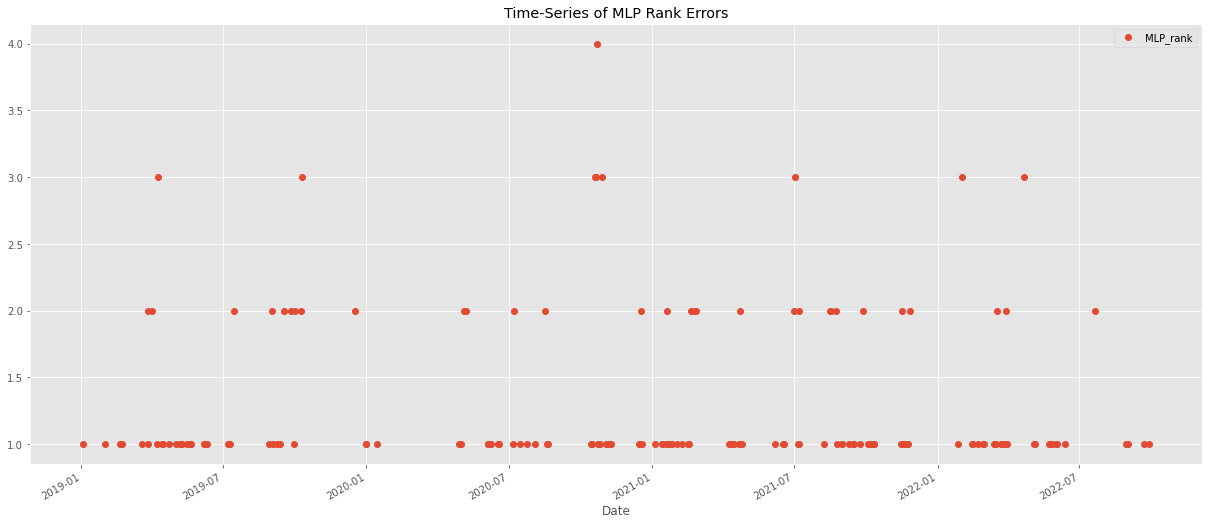

In [ ]:
rank_error.plot(figsize=(21,9), marker="o", linestyle="", title="Time-Series of MLP Rank Errors")

In [ ]:
accuracy_on_best_rank = (
    ranker_accuracy.query("observed_rank==10 and MLP_rank==10").shape[0]
    /ranker_accuracy.query("observed_rank==10").shape[0]
    )
print(f"Accuracy on (sklearn) Multilayer Perceptron {100*accuracy_on_best_rank:.2f}%")

Accuracy on (sklearn) Multilayer Perceptron 83.83%


#### Bonus-Track: Random Picking

In [ ]:
observed_rank_wide.columns.tolist()

['AUD', 'CAD', 'CHF', 'DKK', 'GBP', 'JPY', 'NOK', 'NZD', 'SEK', 'USD']

In [ ]:
np.random.seed = 20221101
#np.random.seed = 100

random_picking_wide = (
    pd.DataFrame(
        np.array([np.random.permutation(np.array(range(10)))+1 for dates in data.index.unique()]),
        index=data.index.unique(),
        columns=observed_rank_wide.columns.tolist()
    )
)

In [ ]:
random_picking_wide

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,3,4,9,8,10,6,7,1,2,5
2004-05-26,2,6,4,10,9,3,8,7,5,1
2004-05-27,7,8,10,6,2,5,9,1,4,3
2004-05-28,1,4,2,7,6,5,3,8,9,10
2004-05-31,2,9,3,5,10,4,8,7,6,1
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,4,3,10,2,9,1,8,6,5,7
2022-09-26,4,3,5,6,2,1,10,8,7,9
2022-09-27,9,4,8,6,7,1,3,5,10,2


In [ ]:
random_picking_tidy = (
    pd.melt(
        random_picking_wide,        
        var_name="symbols",
        value_name="random_rank",
        ignore_index=False
    )
    .reset_index()
    .sort_values(by=["Date","symbols"])    
)

In [ ]:
random_picking_tidy.set_index("Date", inplace=True)

In [ ]:
random_picking_tidy

,symbols,random_rank
Date,,
2004-05-25,AUD,2
2004-05-25,CAD,6
2004-05-25,CHF,4
2004-05-25,DKK,8
2004-05-25,GBP,10
...,...,...
2022-09-29,JPY,1
2022-09-29,NOK,10
2022-09-29,NZD,5


In [ ]:
rankers_tidy = pd.merge(
    ranker_accuracy.reset_index(),
    random_picking_tidy.reset_index(),
    on=["Date","symbols"]
)
rankers_tidy.head()

,Date,symbols,observed_rank,MLP_rank,random_rank
0,2019-01-01,AUD,5,4,10
1,2019-01-01,CAD,1,1,2
2,2019-01-01,CHF,7,7,8
3,2019-01-01,DKK,4,3,3
4,2019-01-01,GBP,3,5,1


In [ ]:
rankers_tidy.query("observed_rank==10 and random_rank==10")

,Date,symbols,observed_rank,MLP_rank,random_rank
47,2019-01-07,NZD,10,10,10
127,2019-01-17,NZD,10,10,10
137,2019-01-18,NZD,10,10,10
157,2019-01-22,NZD,10,10,10
197,2019-01-28,NZD,10,10,10
...,...,...,...,...,...
9259,2022-07-20,USD,10,10,10
9282,2022-07-25,CHF,10,10,10
9549,2022-08-30,USD,10,9,10
9612,2022-09-08,CHF,10,10,10


In [ ]:
tp = rankers_tidy.query("observed_rank==10 and random_rank==10").shape[0]
total = rankers_tidy.query("observed_rank==10").shape[0]

print(f"Accuracy on Random Guess {100*tp/total:.1f}%")

Accuracy on Random Guess 9.3%


Thus, we see that train even naive **Machine Learning** algorithms learn ranking of relevant assets over the time-series considered.
Let us show the implied cumulative wealth by random picking currencies at each time under consideration:

In [ ]:
rankers_tidy.query("observed_rank==10")[["Date","MLP_rank","random_rank"]]

,Date,MLP_rank,random_rank
5,2019-01-01,10,4
15,2019-01-02,10,5
25,2019-01-03,10,7
37,2019-01-04,9,5
47,2019-01-07,10,10
...,...,...,...
9729,2022-09-23,10,3
9739,2022-09-26,10,9
9749,2022-09-27,10,7
9752,2022-09-28,9,7


In [ ]:
rnd_best_curr = (random_picking_wide==10).shift(1)

In [ ]:
rnd_best_curr

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-26,False,False,False,False,True,False,False,False,False,False
2004-05-27,True,False,False,False,False,False,False,False,False,False
2004-05-28,False,False,False,False,False,True,False,False,False,False
2004-05-31,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,False,False,True,False,False,False,False,False,False,False
2022-09-26,False,True,False,False,False,False,False,False,False,False
2022-09-27,False,False,False,False,False,True,False,False,False,False


In [ ]:
random_portfolio_choice = rankers_tidy.query("random_rank==10")[["Date","symbols"]]

In [ ]:
random_portfolio_choice["symbols_1"] = random_portfolio_choice["symbols"].shift(1)
random_portfolio_choice["trade_signal"] = (random_portfolio_choice["symbols"]!=random_portfolio_choice["symbols_1"]).astype("int").shift(1)
random_portfolio_choice.set_index("Date",inplace=True)

In [ ]:
random_portfolio_choice

,symbols,symbols_1,trade_signal
Date,,,
2019-01-01,AUD,NaN,NaN
2019-01-02,NZD,AUD,1.0
2019-01-03,SEK,NZD,1.0
2019-01-04,CHF,SEK,1.0
2019-01-07,NZD,CHF,1.0
...,...,...,...
2022-09-23,CAD,CHF,1.0
2022-09-26,JPY,CAD,1.0
2022-09-27,GBP,JPY,1.0


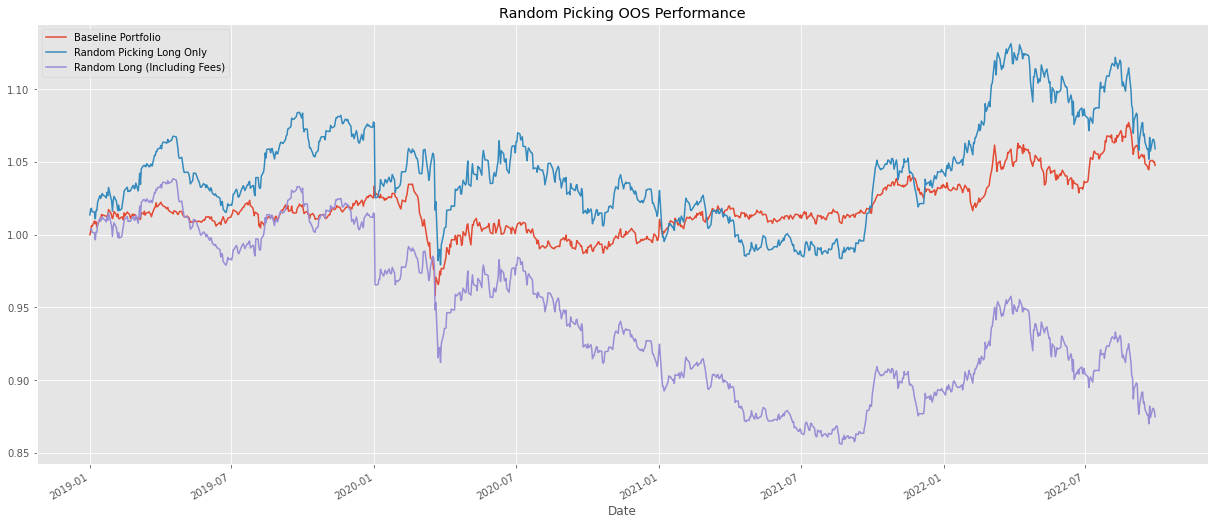

In [ ]:
plt.style.use("ggplot")

(1+fx_rates.pct_change()[best_curr.index[0]:].mean(axis=1,skipna=True)).rename("Baseline Portfolio").cumprod().plot(
    figsize=(21,9), 
    legend=True, 
    title="Random Picking OOS Performance"
    )

(1+fx_rates.pct_change()[best_curr.index[0]:][rnd_best_curr].mean(axis=1,skipna=True)).rename("Random Picking Long Only").cumprod().plot(legend=True)
(1+fx_rates.pct_change()[best_curr.index[0]:][rnd_best_curr].mean(axis=1,skipna=True)-0.02/100*random_portfolio_choice["trade_signal"]).rename(
    "Random Long (Including Fees)"
    ).cumprod().plot(legend=True);

#plt.semilogy();

### 6.4 More Advanced Modelling 

#### 6.4.1 Regress-Then-Rank II: Time-Series Cross-Validated `ElasticNet()`

Rolling calibration with hyperparameter tuning (See [TimeSeriesSplit() scheme](./TimeSeriesSplit_demo.ipynb) with Rolling Window Traing and Forward Validation).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

In [4]:
return_data = pd.read_csv(
    PATH + "fx_data/20220929_FX_dataset_daily_raw_targets.csv",
    index_col="Date",
    parse_dates=["Date"]
)

return_data.head(5)

,symbols,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,...,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,,,,,,,,,,,,,,,,,
2004-05-25,AUD,0.015731,-0.006082,-0.055614,-0.056316,0.122640,0.794805,0.270957,0.910624,-0.248948,...,-0.079603,-0.024478,-6.285969e-03,0.385849,0.720941,0.875331,-0.000117,-0.022878,-0.014408,-0.004832
2004-05-25,CAD,0.000904,-0.007593,-0.034287,0.007412,0.112732,-1.323725,-1.161080,0.056922,-0.338098,...,-0.043225,0.470260,-8.575954e-03,0.629543,1.050538,0.828748,0.000362,-0.012096,0.109706,-0.007627
2004-05-25,CHF,-0.004871,-0.000909,0.007079,0.023576,0.035568,-1.304436,-0.535555,-0.972269,-0.128332,...,4.608029,4.215688,7.449488e-01,1.559042,1.463008,1.085825,0.000065,0.595035,1.174162,0.454858
2004-05-25,DKK,0.000148,0.000134,0.000094,0.001653,0.002823,-0.529057,-0.218269,0.371664,0.238987,...,0.753529,3.150276,-1.595831e-07,1.098828,1.462902,0.995638,0.000108,0.375732,0.999559,0.140704
2004-05-25,GBP,0.013034,0.011086,-0.005693,0.000449,0.087013,0.546624,0.836331,1.063399,0.639579,...,-0.004589,0.085334,1.711806e+00,0.898997,1.010222,1.217466,0.000750,-0.000586,0.045550,0.936243


In [5]:
print(return_data.columns.tolist())

['symbols', 'MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M', 'SKR1M', 'SKR3M', 'SKR6M', 'VARR1M99', 'VARR1M95', 'VARR1M90', 'VARR1M80', 'VARR3M99', 'VARR3M95', 'VARR3M90', 'VARR3M80', 'VARR6M99', 'VARR6M95', 'VARR6M90', 'VARR6M80', 'RACHEV1M99', 'RACHEV1M95', 'RACHEV1M90', 'RACHEV1M80', 'RACHEV3M99', 'RACHEV3M95', 'RACHEV3M90', 'RACHEV3M80', 'RACHEV6M99', 'RACHEV6M95', 'RACHEV6M90', 'RACHEV6M80', 'SORTINO1M', 'SORTINO3M', 'SORTINO6M', 'OMEGA1M', 'OMEGA3M', 'OMEGA6M', 'RAWRET1DAH', 'RAWISR1M', 'RAWISR3M', 'RAWISR6M']


In [6]:
return_data.describe().loc["max",:]

MOM1W         2.102076e-01
MOM2W         2.248455e-01
MOM1M         3.324727e-01
MOM3M         4.496083e-01
EWVOL3M       6.630379e-01
SRET1D        5.702393e+00
SRET3D        4.120339e+00
SRET1W        4.246628e+00
SRET2W        4.055216e+00
SRET1M        3.636990e+00
ISR1M         4.615173e+00
ISR3M         3.306286e+00
ISR6M         3.402702e+00
SKR1M         2.372829e+00
SKR3M         3.182765e+00
SKR6M         3.076750e+00
VARR1M99      4.469305e+01
VARR1M95      2.892298e+01
VARR1M90               inf
VARR1M80               inf
VARR3M99      8.797302e+00
VARR3M95      6.374162e+00
VARR3M90      3.227575e+00
VARR3M80      4.565336e+00
VARR6M99      4.461285e+00
VARR6M95      2.508594e+00
VARR6M90      2.142819e+00
VARR6M80      2.688150e+00
RACHEV1M99    1.202984e+06
RACHEV1M95    2.035014e+05
RACHEV1M90    3.130043e+05
RACHEV1M80    1.196237e+05
RACHEV3M99    1.709493e+07
RACHEV3M95    1.484308e+06
RACHEV3M90    4.634649e+05
RACHEV3M80    3.109202e+03
RACHEV6M99    4.085656e+06
R

In [168]:
# Discarding piece of data for pure testing purposes (last 3y)
target = ["RAWISR3M"]

# Excluding Anomalies on VaR and Potential Targets
X = return_data[:"2018"].loc[:,~return_data.columns.isin(["symbols","VARR1M90", "VARR1M80", "RAWRET1DAH", "RAWISR1M", "RAWISR3M", "RAWISR6M"])]
y = return_data[:"2018"].loc[:,target]

# The Test Set
X_test = return_data["2019":].loc[:,~return_data.columns.isin(["symbols","VARR1M90", "VARR1M80", "RAWRET1DAH", "RAWISR1M", "RAWISR3M", "RAWISR6M"])]
y_test = return_data["2019":].loc[:,target]

In [172]:
X_test.head()

,MOM1W,MOM2W,MOM1M,MOM3M,EWVOL3M,SRET1D,SRET3D,SRET1W,SRET2W,SRET1M,...,RACHEV6M99,RACHEV6M95,RACHEV6M90,RACHEV6M80,SORTINO1M,SORTINO3M,SORTINO6M,OMEGA1M,OMEGA3M,OMEGA6M
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-0.010183,-0.031430,-0.057585,-0.009233,0.082779,-0.989273,-1.792159,-0.873276,-1.905997,-2.409774,...,32.118445,13.719327,7.388274,3.509690,-0.063562,-0.002029,-0.003211,0.275329,0.932227,0.864372
2019-01-01,-0.008502,-0.026926,-0.039187,-0.055194,0.069292,-0.840631,-1.896561,-0.871092,-1.950686,-1.959068,...,37.068282,13.503235,7.776977,3.815468,-0.031777,-0.012500,-0.001508,0.320323,0.580722,0.933453
2019-01-01,-0.005123,-0.004946,0.000353,0.005299,0.044046,-2.218748,-0.470495,-0.825688,-0.563713,0.027782,...,74.313304,52.679827,14.370588,4.982987,0.159920,0.714751,1.630136,1.021220,1.088632,1.205166
2019-01-01,-0.000013,0.000121,-0.000526,-0.001426,0.002342,0.363128,-1.388600,-0.040454,0.258404,-0.778431,...,19.844257,10.068630,6.261437,3.188637,-0.000011,-0.000010,-0.000006,0.609460,0.622303,0.758536
2019-01-01,-0.006317,-0.003103,-0.014297,-0.017200,0.065932,-0.258839,-0.637818,-0.680212,-0.236271,-0.751164,...,61.920576,16.061874,8.272688,3.894599,-0.008736,-0.003639,-0.001874,0.639995,0.843059,0.895866


In [171]:
y_test.head()

,RAWISR3M
Date,
2019-01-01,0.027216
2019-01-01,-0.006190
2019-01-01,0.674051
2019-01-01,-0.000004
2019-01-01,-0.002129


In [47]:
# Some Experiments with TimeSeriesSplit
instancies_by_date = return_data["symbols"].nunique()

test_size_ = instancies_by_date*252*2          # Fixing test_size to 1y each fold (split)
max_train_size_ = instancies_by_date*252*8   # Fixing max_train_size to 3y each fold (split)

tscv = TimeSeriesSplit(
    max_train_size = max_train_size_,
    test_size=test_size_,
    n_splits=4
)

print(tscv)

TimeSeriesSplit(gap=0, max_train_size=20160, n_splits=4, test_size=5040)


In [48]:
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

TRAIN: [    0     1     2 ... 17607 17608 17609] TEST: [17610 17611 17612 ... 22647 22648 22649]
TRAIN: [ 2490  2491  2492 ... 22647 22648 22649] TEST: [22650 22651 22652 ... 27687 27688 27689]
TRAIN: [ 7530  7531  7532 ... 27687 27688 27689] TEST: [27690 27691 27692 ... 32727 32728 32729]
TRAIN: [12570 12571 12572 ... 32727 32728 32729] TEST: [32730 32731 32732 ... 37767 37768 37769]


In [80]:
X.index[list(tscv.split(X))[1][0].tolist()][0].strftime("%Y-%m-%d")

'2005-05-10'

In [132]:
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [124]:
def build_model(_alpha, _l1_ratio):
    estimator = ElasticNet(
        alpha=_alpha,
        l1_ratio=_l1_ratio,
        fit_intercept=True,                
        precompute=True,        
        copy_X=True,
        tol=0.1,
        warm_start=False,
        positive=False,
        random_state=20221101,
        selection='random'
    )

    return estimator

In [125]:
#scaler = MinMaxScaler()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X) 

In [126]:
model = build_model(_alpha=0.1, _l1_ratio=0.1)
scores = cross_val_score(model, X_scaled, y, cv=tscv, scoring="r2")
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Loss: 0.891 (+/- 0.048)


In [127]:
scores

array([0.93915085, 0.81140806, 0.91562329, 0.89721339])

* Excerpt from `sklearn` documentation:

Linear regression with combined L1 and L2 priors as regularizer.

Minimizes the objective function:

$$
\frac{1}{2 n} ||y - Xw||^2_2
+ \alpha\, \lambda \cdot ||w||_1
+ \frac{1}{2} \alpha (1 - \lambda) \cdot ||w||^2_2
$$

If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:

$$
a ||w||_1 + \frac{1}{2} b ||w||_2^2
$$

where:

$$\alpha = a + b\quad \mathrm{and}\quad \lambda = \frac{a}{a + b}$$

In [144]:
params = {    
    'estimator__l1_ratio': [.1, .5, .7, .9, .95, .99, 1]
}

finder = ElasticNetCV(
    l1_ratio= [.1, .5, .7, .9, .95, .99, 1],                
    cv=tscv,  # change this to the splitter subject to test
    verbose=1,        
    n_jobs=-1,
    selection="random",
    random_state=20221101            
)

In [145]:
finder

ElasticNetCV(cv=TimeSeriesSplit(gap=0, max_train_size=20160, n_splits=4, test_size=5040),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], n_jobs=-1,
             random_state=20221101, selection='random', verbose=1)

In [146]:
finder.fit(X_scaled, y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(cv=TimeSeriesSplit(gap=0, max_train_size=20160, n_splits=4, test_size=5040),
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], n_jobs=-1,
             random_state=20221101, selection='random', verbose=1)

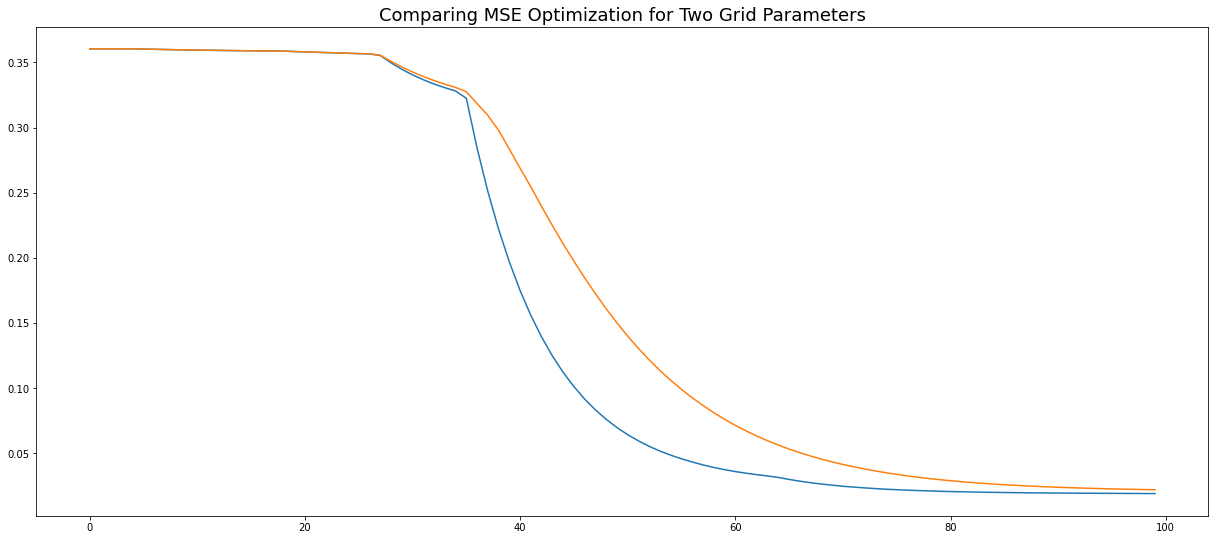

In [166]:
fig, ax = plt.subplots(1,1, figsize=(21,9))

ax.plot(finder.mse_path_[-1,:,0])
ax.plot(finder.mse_path_[0,:,0])
ax.set_title("Comparing MSE Optimization for Two Grid Parameters", fontsize=18);

In [ ]:
X_test_sc = scaler.transform(X_test)

Score Results are very similar to the reported for LR and (static validated) MLP, and a priori insufficient for correct ranking (accuracy on top currency maybe similar to the MLP case ~83%)

In [178]:
print(f"R2 on ts-Cross-Validated Train Set: {100*finder.score(X_scaled, y):.1f}%")
print(f"R2 on Test Set: {100*finder.score(X_test_sc, y_test):.1f}%")

R2 on ts-Cross-Validated Train Set: 94.0%
R2 on Test Set: 92.8%


In [179]:
# CV Model Summary Metrics
title_str = "ElasticNet Weight Best Params:"
n_underlines = len(title_str)

alpha = finder.alpha_
lambda_ = finder.l1_ratio_
a = alpha*lambda_
b = alpha*(1-lambda_)

print(title_str)
print("="*n_underlines)
print(f"alpha: {alpha}")
print(f"l1_ratio: {lambda_}")
print(f"a: {a:0.2f}")
print(f"b: {b:0.2f}")

ElasticNet Weight Best Params:
alpha: 0.005939143224133163
l1_ratio: 1.0
a: 0.01
b: 0.00


In [180]:
# Generalization Capabilities. Refit with best parameters the Whole Training Set 200710-201910
model = build_model(
    _alpha=finder.alpha_, 
    _l1_ratio=finder.l1_ratio_
)

# train model
model.fit(X_scaled, y)

ElasticNet(alpha=0.005939143224133163, l1_ratio=1.0, precompute=True,
           random_state=20221101, selection='random', tol=0.1)

In [181]:
# test score
y_predicted = model.predict(X_test_sc)
#score = r2_score(y_test, y_predicted, multioutput='uniform_average') ????
score = r2_score(y_test, y_predicted)
print(f"Test Loss: {100*score:.2f}%")

Test Loss: 91.91%


In [195]:
predictions_tidy_LASSO = return_data["2019":][["symbols"]]


,symbols
Date,
2019-01-01,AUD
2019-01-01,CAD
2019-01-01,CHF
2019-01-01,DKK
2019-01-01,GBP
...,...
2022-09-29,JPY
2022-09-29,NOK
2022-09-29,NZD


In [198]:
predictions_tidy_EN = pd.concat([
    predictions_tidy_LASSO,
    y_test]
    ,axis=1
)

del predictions_tidy_LASSO
import gc
gc.collect()

4066

In [200]:
predictions_tidy_EN["RAWISR3M_EN"] = y_predicted
predictions_tidy_EN

,symbols,RAWISR3M,RAWISR3M_EN
Date,,,
2019-01-01,AUD,0.027216,-0.011245
2019-01-01,CAD,-0.006190,-0.033137
2019-01-01,CHF,0.674051,0.282316
2019-01-01,DKK,-0.000004,-0.069890
2019-01-01,GBP,-0.002129,0.038192
...,...,...,...
2022-09-29,JPY,-0.000036,0.138168
2022-09-29,NOK,-0.004702,0.044655
2022-09-29,NZD,-0.003284,0.026184


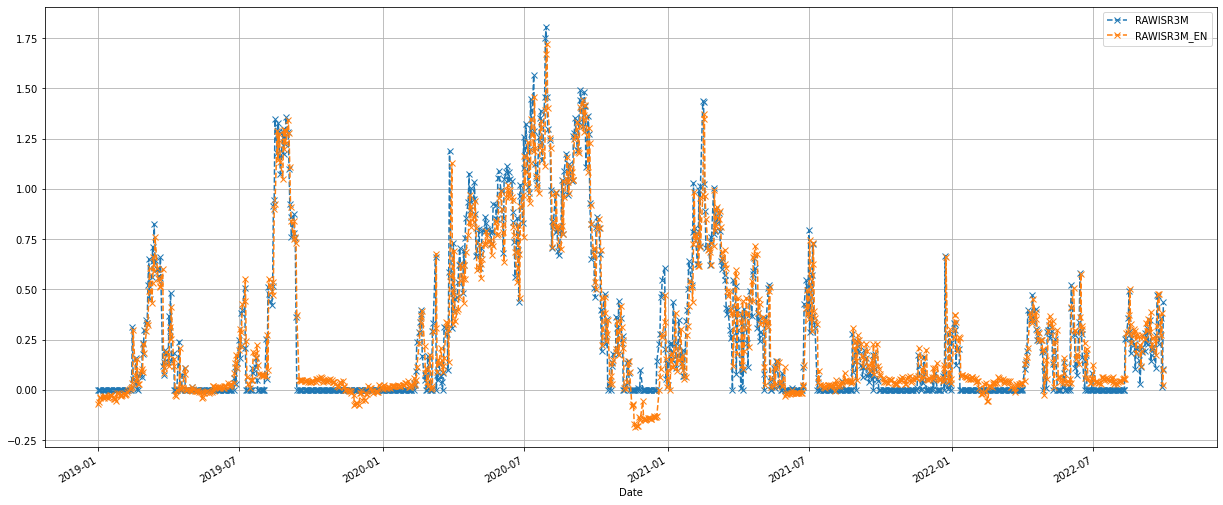

In [210]:
predictions_tidy_EN.query("symbols=='DKK'").plot(figsize=(21,9), marker="x", linestyle="--")
plt.grid();

In [218]:
predictions_tidy_EN.query("symbols=='USD'").describe().loc["min",:]

RAWISR3M      -0.012682
RAWISR3M_EN   -0.119863
Name: min, dtype: float64

In [221]:
predictions_rank_wide_EN = (
    pd.pivot(
        predictions_tidy_EN[["symbols","RAWISR3M_EN"]],
        columns="symbols",
        values="RAWISR3M_EN"
    )
).rank(axis=1)

In [226]:
predictions_rank_tidy_EN = (
  pd.melt(
    predictions_rank_wide_EN,    
    value_name="EN_rank",
    ignore_index=False
  )
  .reset_index()
  .sort_values(by=["Date","symbols"])
  .set_index("Date")
)

In [227]:
observed_rank_tidy = (
    pd.read_csv(
        PATH + "fx_data/20220929_FX_quantized_targets.csv",
        index_col = "Date",
        parse_dates = ["Date"]
    )[["symbols","ISR3M"]]
)
observed_rank_tidy

,symbols,ISR3M
Date,,
2004-05-24,AUD,2
2004-05-24,CAD,5
2004-05-24,CHF,9
2004-05-24,DKK,8
2004-05-24,GBP,3
...,...,...
2022-09-29,JPY,6
2022-09-29,NOK,1
2022-09-29,NZD,3


In [231]:
observed_rank_tidy.columns

Index(['symbols', 'ISR3M'], dtype='object')

In [239]:
accuracy_ranker_EN = (
    pd.merge(
        observed_rank_tidy.reset_index(),
        predictions_rank_tidy_EN.reset_index(),
        how="inner",
        on=["Date","symbols"]
    ).set_index("Date")
)

In [268]:
accuracy_ranker_EN

,symbols,ISR3M,EN_rank
Date,,,
2019-01-01,AUD,5,4.0
2019-01-01,CAD,1,2.0
2019-01-01,CHF,7,7.0
2019-01-01,DKK,4,1.0
2019-01-01,GBP,3,5.0
...,...,...,...
2022-09-29,JPY,6,6.0
2022-09-29,NOK,1,3.0
2022-09-29,NZD,3,2.0


In [269]:
accuracy_ranker_EN.query("ISR3M==10 and EN_rank==10")

,symbols,ISR3M,EN_rank
Date,,,
2019-01-01,JPY,10,10.0
2019-01-02,JPY,10,10.0
2019-01-03,JPY,10,10.0
2019-01-07,NZD,10,10.0
2019-01-08,NZD,10,10.0
...,...,...,...
2022-09-21,CHF,10,10.0
2022-09-23,USD,10,10.0
2022-09-26,USD,10,10.0


In [249]:
(
  accuracy_ranker_EN.query("ISR3M==10 and EN_rank==10").shape[0]/
  accuracy_ranker_EN.query("ISR3M==10").shape[0]
)

0.8300921187308086

In [246]:
# Accuracy is worse for Long-Short Trades
(
accuracy_ranker_EN.query(
    "ISR3M==10 and EN_rank==10 or ISR3M==1 and EN_rank==1"
    ).shape[0]/accuracy_ranker_EN.query("ISR3M==10 or ISR3M==1").shape[0]
)

0.6944728761514841

In [250]:
fx_rates = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [274]:
best_curncy = (predictions_rank_wide_EN==10).shift(1)
next_to_top_curncy = (predictions_rank_wide_EN==9).shift(1)
worst_curncy = (predictions_rank_wide_EN==1).shift(1)

<AxesSubplot:title={'center':'LASSO Regression for Rank Currencies'}, xlabel='Date'>

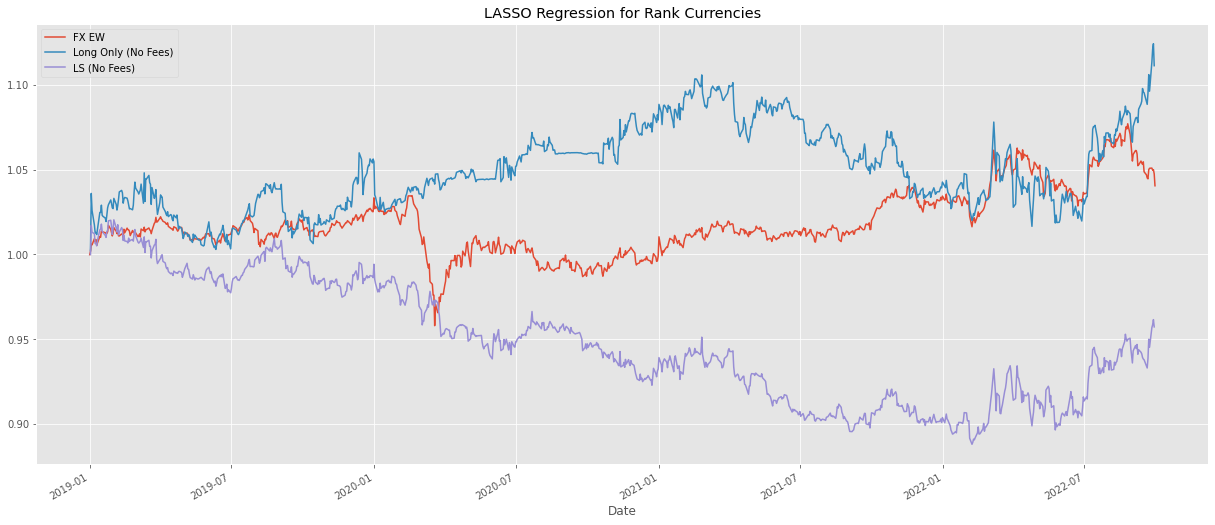

In [275]:
plt.style.use("ggplot")

(1+fx_rates.pct_change()[best_curncy.index[0]:].mean(axis=1,skipna=True)).rename("FX EW").cumprod().plot(figsize=(21,9), legend=True, title="LASSO Regression for Rank Currencies")
(1+fx_rates.pct_change()[best_curncy.index[0]:][best_curncy].mean(axis=1,skipna=True)).rename("Long Only (No Fees)").cumprod().plot(figsize=(21,9), legend=True) 
(1+0.5*fx_rates.pct_change()[best_curncy.index[0]:][best_curncy].mean(axis=1,skipna=True)+0.5*fx_rates.pct_change()[best_curncy.index[0]:][next_to_top_curncy].mean(axis=1,skipna=True)).rename("LS (No Fees)").cumprod().plot(figsize=(21,9), legend=True)
#(1+0.5*fx_rates.pct_change()[best_curncy.index[0]:][best_curncy].mean(axis=1,skipna=True)-0.5*fx_rates.pct_change()[best_curncy.index[0]:][worst_curncy].mean(axis=1,skipna=True)).rename("LS (No Fees)").cumprod().plot(figsize=(21,9), legend=True)


**Rankers** Training ToDoS:

1. Try some other Regression Models with `tscv` Cross-Validation scheme, eg SVM and/or XGBoost (LightGBM).
2. Try LETOR Pointwise (Ordinal Regression)
3. Try LETOR Pairwise (LambdaMART, from LightGBM)


**Checkpoint**:

1. Reset Kernel
2. Reload [Core Melted Return Data with Running Features and Targets](./data/config/20220831_last_dataset_monthly.csv):
    
    - `pd.read_csv(
      PATH + "fx_data/....csv")`
    - `pd.DataFrame.head()`

#### 6.4.2 RtR II: `XGBRegressor`

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [ ]:
from weakref import ref
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

# hp function helper

def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(
        estimator = xgb_model,
        param_grid = param_tuning,                        
        scoring = 'r2', #R2
        #scoring = 'neg_mean_absolute_error', #MAE
        #scoring = 'neg_mean_squared_error',  #MSE
        n_jobs = 5,
        refit=True,
        cv = tscv,      
        verbose = 3
    )

    gsearch.fit(X_train,y_train)

    return gsearch